# Make predictions

## Load data and investigate

In [82]:
import csv
import sys
import ast

import pandas as pd
import numpy as np

# read in pickle file 
prep = "_" # "_preprocessed_" #   
checkpoint = 'bert-base-uncased' 
 

dataA = pd.read_pickle("dataA"+ prep + checkpoint +  ".pkl")

In [83]:
dataA["subset"].value_counts()

Train     60
Dev       15
Test      15
Sample    10
Name: subset, dtype: int64

In [84]:
dataA['sentence_type'].value_counts()

idiomatic    39
literal      31
Name: sentence_type, dtype: int64

In [85]:
# returns the dataframe sample and train (data items that have literal/idiomatic information given)
def only_train(dataA): # returns the dataframe sample and train (data items that have literal/idiomatic information given)
    return pd.concat([dataA[dataA["subset"] == "Sample"],dataA[dataA["subset"]== "Train"]])

In [86]:
# functions to display images

from PIL import Image
from IPython.display import display


fileDirectory = 'D:\\Wiebke Petersen\\Downloads\\AdMIRe Subtask A Train\\train'

# Open the image file
def display_image(compound, fn):
    img = Image.open(fileDirectory + "\\" + compound + "\\" + fn)
    new_size = (150, 150)  # Width, Height
    img_resized = img.resize(new_size)  
    # Display the image
    display(img_resized)

# returns list of image names sorted from image1 to image5
def get_image_names(n,mydata):
    names = []
    for i in [1,2,3,4,5]:
         names.append(mydata['image' + str(i) + '_name'][n])
    return names


In [87]:
# print information of 1 item:

def print_item(n, mydata):
    # print  'sentence_type', 'sentence'
    compound = mydata['compound'][n]
    print(compound)
    print(mydata['sentence_type'][n])
    print(mydata['sentence'][n])
    print('---------------------------------------------------------------------')


    # for image_names in 'expected_order' print image_captions
    names  =  get_image_names(n,mydata)
    expected_order = mydata['expected_order'][n]
    print(expected_order)

    for image_name in expected_order:
        display_image(compound, image_name)
        # get index of image_name in names
        index = names.index(image_name) + 1
        print(mydata['image'+str(index)+'_caption'][n])
    

top dog
literal
The top dog in the neighborhood seemed to be guarding the alley from passing cats all day.
---------------------------------------------------------------------
['62040589986.png', '43207170783.png', '38568900802.png', '76177115752.png', '44297130521.png']


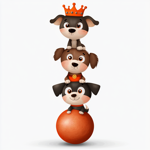

The image depicts three cartoon dogs stacked on top of each other, forming a pyramid-like structure. The dogs are illustrated in a cute and playful style.\n\n1. **Top Dog**: \n   - This dog is wearing an orange crown with a gold emblem at the center.\n   - It has brown fur with white accents around its eyes and ears.\n   - Its expression appears to be happy or content.\n\n2. **Middle Dog**:\n   - This dog is wearing a red collar with a gold emblem.\n   - It also has brown fur with white accents around its eyes and ears.\n   - Its expression is similar to the top dog, appearing happy or content.\n\n3. **Bottom Dog**:\n   - This dog is sitting on a large orange ball.\n   - It has black fur with white accents around its eyes and ears.\n   - Its expression is cheerful, with a slight smile.\n\nThe overall scene conveys a sense of balance and harmony, with each dog supporting the one above it. The use of bright colors and simple shapes makes the image visually appealing and engaging.


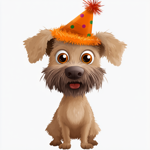

The image depicts a cartoon dog wearing an orange party hat with a pom-pom on top. The dog has a light brown coat, large brown eyes, and a black nose. It appears to be sitting and smiling, giving off a cheerful and festive vibe.


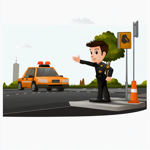

The image depicts a cartoon-style scene of a traffic officer directing traffic at an intersection. The officer is standing on a raised pedestrian crossing, wearing a black uniform with a star badge on the chest and a cap. The officer's right arm is extended, signaling vehicles to stop or proceed as needed.\n\nIn the background, there is a yellow taxi with its lights on, indicating it might be stopped or slowing down. The taxi is positioned on the left side of the image, facing towards the officer. The road is marked with white dashed lines, and there is a traffic cone placed near the officer, possibly to guide or direct traffic.\n\nTo the right of the officer, there is a pedestrian crossing sign with a symbol of a person walking, indicating that it is safe for pedestrians to cross. Behind the sign, there is a tree and some bushes, adding a touch of greenery to the scene. In the distance, there is a tall building visible, suggesting an urban setting.\n\nThe sky is clear with a few cloud

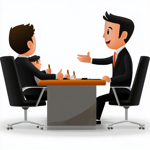

The image depicts a business meeting scenario. There are three individuals seated around a rectangular conference table. The person on the right is wearing a dark suit with an orange tie and is gesturing with his left hand, possibly explaining something to the others. The two people on the left are dressed in similar dark suits and appear to be listening attentively. They each have a pen in their hands, suggesting they might be taking notes or preparing to do so. The setting appears to be a professional office environment, indicated by the modern office chairs and the formal attire of the individuals.


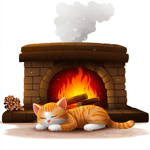

The image depicts a cozy scene featuring a brick fireplace with a warm, glowing fire burning inside. The flames are bright and orange, casting a soft light around the hearth. In front of the fireplace, there is a cute, orange tabby cat with white paws and a white face, lying down and sleeping peacefully. The cat's eyes are closed, and it appears to be enjoying the warmth of the fire. To the left of the fireplace, there is a pine cone, adding to the rustic and homely atmosphere. The overall scene conveys a sense of comfort and relaxation, typical of a cold winter day by the fireplace.


In [88]:
dataA_train = only_train(dataA)
print_item(27,dataA_train)

## Binary classification idiomatic/literal via cosine similarities

### Binary classification via cosine similarities using chatGPT data

In [89]:
def cosine_similarity(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))


def compare(emb,emb0,emb1):
    sim0 = cosine_similarity(emb,emb0)
    sim1 = cosine_similarity(emb,emb1)
    if sim0 > sim1:
        return 0
    else:
        return 1

def binary2values(list,val0,val1):
    final = []
    for element in list:
        if element == 1:
            final.append(val1)
        else:
            final.append(val0)
    return final


In [90]:
#keep_columns = [c for c in dataA.columns if "embedding" not in c]
#dataA_pred = dataA[dataA.columns.intersection(keep_columns)]


In [91]:
compound_methods = ['meanSecondToLast','meanLast4','meanLast','meanFirst']
methods = ['meanSecondToLast','meanLast4','meanLast','meanFirst','firstCLS','lastCLS']


In [92]:
# only training data has sentence_type information
dataA_train = only_train(dataA)


from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

##### sentence embedding versus gpt sentence/meaning embedding

In [93]:
# systematic analysis sentence compared to gpt sentence embeddings
gpt_sents = ["sentence", "meaning"]


print("sentence compared to gpt sentence embeddings")
for sent in gpt_sents:
    for m in methods:
        pred = dataA_train.apply(lambda x: compare(x["sentence_embedding_" + m],
                                         x["gpt_literal_" + sent + "_embedding_" + m], 
                                         x["gpt_idiomatic_" + sent + "_embedding_" + m]), axis=1)
        pred = binary2values(pred,"literal","idiomatic")

        # evaluate
        print(sent + "_embedding_" + m)
        y = dataA_train["sentence_type"]
        print(round(accuracy_score(y, pred),2))
#        print(classification_report(y, pred,zero_division=0))


sentence compared to gpt sentence embeddings
sentence_embedding_meanSecondToLast
0.83
sentence_embedding_meanLast4
0.76
sentence_embedding_meanLast
0.84
sentence_embedding_meanFirst
0.51
sentence_embedding_firstCLS
0.56
sentence_embedding_lastCLS
0.83
meaning_embedding_meanSecondToLast
0.79
meaning_embedding_meanLast4
0.73
meaning_embedding_meanLast
0.79
meaning_embedding_meanFirst
0.64
meaning_embedding_firstCLS
0.56
meaning_embedding_lastCLS
0.66


compound in sentence embedding versus compound in gpt sentence/meaning embedding

In [94]:
# systematic analysis compound embeddings
gpt_sents = ["sentence", "meaning"]

print("compound in sentence compared to gpt compound in sentence embeddings")
for sent in gpt_sents:
    for m in compound_methods:
        pred = dataA_train.apply(lambda x: compare(x["compound_embedding_sentence_" + m],
                                         x["compound_embedding_gpt_literal_" + sent + "_" + m], 
                                         x["compound_embedding_gpt_idiomatic_" + sent + "_" + m]), axis=1)
        pred = binary2values(pred,"literal","idiomatic")

        # evaluate
        print(sent + "_embedding_" + m)
        y = dataA_train["sentence_type"]
        print(round(accuracy_score(y, pred),2))
#        print(classification_report(y, pred,zero_division=0))


compound in sentence compared to gpt compound in sentence embeddings
sentence_embedding_meanSecondToLast
0.9
sentence_embedding_meanLast4
0.9
sentence_embedding_meanLast
0.86
sentence_embedding_meanFirst
0.47
meaning_embedding_meanSecondToLast
0.74
meaning_embedding_meanLast4
0.74
meaning_embedding_meanLast
0.67
meaning_embedding_meanFirst
0.54


Winner: compound in sentence embedding versus compound in gpt-sentence embedding with methods meanSecondToLast or meanLast4 

In [95]:
# systematic analysis compound embeddings of winning systems
gpt_sents = ["sentence"]

print("compound in sentence compared to gpt compound in sentence embeddings")
for sent in gpt_sents:
    for m in ["meanSecondToLast", "meanLast4"]:
        pred = dataA_train.apply(lambda x: compare(x["compound_embedding_sentence_" + m],
                                         x["compound_embedding_gpt_literal_" + sent + "_" + m], 
                                         x["compound_embedding_gpt_idiomatic_" + sent + "_" + m]), axis=1)
        pred = binary2values(pred,"literal","idiomatic")

        # evaluate
        print(sent + "_embedding_" + m)
        y = dataA_train["sentence_type"]
        print(round(accuracy_score(y, pred),2))
        print(classification_report(y, pred,zero_division=0))


compound in sentence compared to gpt compound in sentence embeddings
sentence_embedding_meanSecondToLast
0.9
              precision    recall  f1-score   support

   idiomatic       0.92      0.90      0.91        39
     literal       0.88      0.90      0.89        31

    accuracy                           0.90        70
   macro avg       0.90      0.90      0.90        70
weighted avg       0.90      0.90      0.90        70

sentence_embedding_meanLast4
0.9
              precision    recall  f1-score   support

   idiomatic       0.92      0.90      0.91        39
     literal       0.88      0.90      0.89        31

    accuracy                           0.90        70
   macro avg       0.90      0.90      0.90        70
weighted avg       0.90      0.90      0.90        70



## Binary classification idiomatic/literal via machine learning model

#### sentence embeddings

Trained on sentence embeddings. No ChatGPT data is used

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# mlp
from sklearn.neural_network import MLPClassifier
# knn
from sklearn.neighbors import KNeighborsClassifier


# evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


dataA_train = only_train(dataA)

print("Trained on sentence embeddings. No ChatGPT data is used")
print("===========================")
for method in methods: 
    # get data for training (subset column has value train or sample)

    X = dataA_train['sentence_embedding_'+ method].tolist()
    y = dataA_train["sentence_type"]

    # split in train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    print(method)
    # logistic regression
#    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
#    clf = RandomForestClassifier(max_depth=2, random_state=0).fit(X_train, y_train)
    clf = SVC(kernel='linear').fit(X_train, y_train)
#    clf = MLPClassifier(random_state=0, max_iter=300).fit(X_train, y_train)
#    clf = KNeighborsClassifier(n_neighbors=2).fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    print(round(accuracy_score(y_test, y_pred),2))

    #classification report
#    print(classification_report(y_test, y_pred,zero_division=0))



Trained on sentence embeddings. No ChatGPT data is used
meanSecondToLast
0.79
meanLast4
0.71
meanLast
0.71
meanFirst
0.36
firstCLS
0.43
lastCLS
0.93


Be careful, results depend very much on random_state value in train-test-split

In [97]:

for rs in [0,1,2,3,4,5,6,10,13,20,42,30]: 
    # get data for training (subset column has value train or sample)
    method = "lastCLS"
    X = dataA_train['sentence_embedding_'+ method].tolist()
    y = dataA_train["sentence_type"]

    # split in train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)

#    print("random_state=", rs)
    # logistic regression
#    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
#    clf = RandomForestClassifier(max_depth=2, random_state=0).fit(X_train, y_train)
    clf = SVC(kernel='linear').fit(X_train, y_train)
#    clf = MLPClassifier(random_state=0, max_iter=300).fit(X_train, y_train)
#    clf = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    print(round(accuracy_score(y_test, y_pred),2))

    #classification report
#    print(classification_report(y_test, y_pred,zero_division=0))



0.93
0.86
0.79
0.86
1.0
0.71
0.71
0.93
0.93
0.86
0.93
0.93


In [98]:
# dummy classifier most frequent
from sklearn.dummy import DummyClassifier


# dummy classifier most frequent
clf = DummyClassifier(strategy="most_frequent")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("dummy classifier most frequent")
print(round(accuracy_score(y_test, y_pred),2))


dummy classifier most frequent
0.5


#### compound embeddings

In [99]:

dataA_train = only_train(dataA)


for method in compound_methods:
    X = dataA_train['compound_embedding_sentence_'+ method].tolist()
    y = dataA_train["sentence_type"]

    # split in train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    print(method)
    # logistic regression
    clf = LogisticRegression(random_state=0).fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    print(round(accuracy_score(y_test, y_pred),2))

    #classification report
#    print(classification_report(y_test, y_pred,zero_division=0))

meanSecondToLast
0.86
meanLast4
0.79
meanLast
0.79
meanFirst
0.21


**Summary:** Best result for sentence embedding with method lastCLS 

## Ranking images by cosine similarity between image caption embeddings and sentence embeddings (no chatGPT data)

In [100]:
from scipy.stats import spearmanr

# evaluation functions for ranked orders
def top1accuracy(pred_rankings,expected_order):
    correct = 0
    for i in range(len(pred_rankings)):
        if pred_rankings[i][0] == expected_order[i][0]:
            correct += 1
    return round(correct/len(pred_rankings),2)


def spearman_correlation(pred_rankings,expected_order):
    corr = []
    for i in range(len(pred_rankings)):
        corr.append(spearmanr(pred_rankings[i],expected_order[i]).correlation)
    return round(np.mean(corr),2)


In [101]:
pred_rankings = []
for i in range(len(dataA)):
    # compare cosine similarity of each picture_caption_embedding_meanLast4 and embedding_meanLast4
    #method = "lastCLS"
    method = "meanLast4"
    #embedding = dataA['sentence_embedding_' + method][i]
    embedding = dataA['compound_embedding_sentence_' + method][i]
    image1_caption_embedding = dataA['image1_caption_embedding_' + method][i]
    image2_caption_embedding = dataA['image2_caption_embedding_' + method][i]
    image3_caption_embedding = dataA['image3_caption_embedding_' + method][i]
    image4_caption_embedding = dataA['image4_caption_embedding_' + method][i]
    image5_caption_embedding = dataA['image5_caption_embedding_' + method][i]
    similarity1 = cosine_similarity(embedding,image1_caption_embedding)
    similarity2 = cosine_similarity(embedding,image2_caption_embedding)
    similarity3 = cosine_similarity(embedding,image3_caption_embedding)
    similarity4 = cosine_similarity(embedding,image4_caption_embedding)
    similarity5 = cosine_similarity(embedding,image5_caption_embedding)
    # sort the similarities
    similarities = [similarity1,similarity2,similarity3,similarity4,similarity5]
    # sort and give indices
    idx = np.argsort(similarities)
    # reverse the indices
    idx = idx[::-1]
    pred_rankings.append(idx)
dataA["pred_rankings"] = pred_rankings

#  replace rank by according image name
for i in range(len(dataA)):
    idxs = pred_rankings[i]
    picture_names = get_image_names(i,dataA)
    # sort picture_names according to idxs
    picture_names = [picture_names[i] for i in idxs]
    dataA["pred_rankings"][i] = picture_names    


In [102]:
dataA_train = only_train(dataA)

print("compare image captions with sentence")
print("top1 accuracy")
print(top1accuracy(dataA_train["pred_rankings"],dataA_train['expected_order']))

print("spearman rank correlation")
print(spearman_correlation(dataA_train["pred_rankings"],dataA_train['expected_order']))



compare image captions with sentence
top1 accuracy
0.21
spearman rank correlation
0.04


**Conclusion:** very bad

## Image ranking prediction via multi-step procedure

Procedure:
 1. decide on sentence: literal or idiomatic
 2. group 5 images into two pairs of very similar captions and one unrelated one
 2. decide which caption pair is the literal and which the idiomatic
 2. depending on decision 1 order the images.

### use gpt sentence/meaning (compound) embeddings to classify image captions 

Ziel: sortiere die 5 Bilder wie folgt
1: literal, 2: ähnlich wie literal, 3: ähnlich wie idiomatic, 4: idiomatic, 5: unrelated 

In [103]:
sim_to_literal = []
sim_to_idiomatic = []
m = "meanLast4"

n = 40

#emb_lit = dataA["gpt_compound_embedding_literal_meaning_" +m][n]
#emb_id = dataA["gpt_compound_embedding_idiomatic_meaning_" +m][n]


emb_lit = dataA["gpt_literal_sentence_embedding_" +m][n]
emb_id = dataA["gpt_idiomatic_sentence_embedding_" +m][n]


#emb_lit = dataA["gpt_literal_meaning_embedding_" +m][n]
#emb_id = dataA["gpt_idiomatic_meaning_embedding_" +m][n]

for i in [1,2,3,4,5]:
    emb_image = dataA["image" + str(i) + "_caption_embedding_" + m][n]
    sim_to_literal.append(cosine_similarity(emb_lit,emb_image))
    sim_to_idiomatic.append(cosine_similarity(emb_id,emb_image))

idx_lit = np.argsort(sim_to_literal )
idx_id = np.argsort(sim_to_idiomatic )
# reverse the indices
idx_lit = idx_lit[::-1].tolist()
idx_id = idx_id[::-1].tolist()


name_list = get_image_names(n,dataA)

name_list_lit = [name_list[j] for j in idx_lit]
name_list_id = [name_list[j] for j in idx_id]



spring chicken
literal
Spring chicken is a literal term for a chicken born in the spring season.


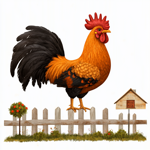

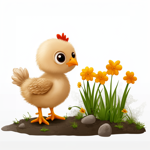

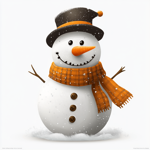

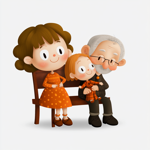

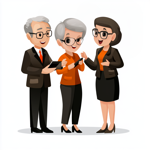

idiomatic
Spring chicken is a metaphor for someone who is young or youthful.


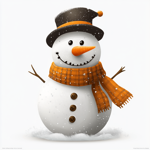

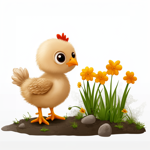

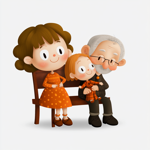

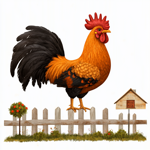

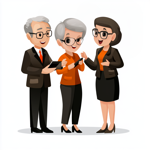

In [104]:
fileDirectory = 'D:\\Wiebke Petersen\\Downloads\\AdMIRe Subtask A Train\\train'

compound = dataA["compound"][n]
print(compound)
print("literal")
print(dataA["gpt_literal_meaning"][n])
for fn in name_list_lit:
    display_image(compound,fn)

print("idiomatic")
print(dataA["gpt_idiomatic_meaning"][n])
for fn in name_list_id:
    display_image(compound,fn)



In [105]:
dataA["expected_order"]

0     [35234427395.png, 53378381715.png, 39938261459...
1     [61697797701.png, 93189810779.png, 89375227504...
2     [86137977215.png, 78062290185.png, 54240592941...
3     [83600499282.png, 57658144685.png, 02512838127...
4     [77861539717.png, 68016869942.png, 11844321898...
                            ...                        
95                                                  NaN
96                                                  NaN
97                                                  NaN
98                                                  NaN
99                                                  NaN
Name: expected_order, Length: 100, dtype: object

In [106]:
# compare all pictures to each other and get 2 pairs of most similar ones.

#m="meanLast4"
m= "lastCLS"
n= 45

dataA["pairs"] = [None for p in range(len(dataA))]

for n in range(len(dataA)):
    sim = np.zeros((5,5))

    for i in range(5):
        emb_image_i = dataA["image" + str(i+1) + "_caption_embedding_" + m][n]
        for j in range(i+1,5):
            emb_image_j = dataA["image" + str(j+1) + "_caption_embedding_" + m][n]
            sim[i,j] = cosine_similarity(emb_image_i,emb_image_j)
        
       
    name_list = get_image_names(n,dataA)
    compound = dataA["compound"][n]
    
    u,v = np.unravel_index(np.argmax(sim),sim.shape) # indices of pair with highest similarity 
    simN = np.delete(sim,[u,v],0)
    simN = np.delete(simN,[u,v],1)
    max = np.max(simN)
    b = np.where(sim == max)
    u1 = b[0][0] # u1,v1 indices of pair with second highest similarity 
    v1 = b[1][0]

    unrel = list(set([0,1,2,3,4])-set([u,v,u1,v1]))[0]
    dataA["pairs"][n] = [[(v+1,u+1),(v1+1,u1+1),unrel+1],[(name_list[v],name_list[u]),(name_list[v1],name_list[u1]),name_list[unrel]]]


     


In [107]:
dataA["pairs"][0][0]

[(3, 1), (5, 4), 2]

In [108]:
dataA["literal_image"] = [None for p in range(len(dataA))]
dataA["idiomatic_image"] = [None for p in range(len(dataA))]
dataA["unrelated_image"] = [None for p in range(len(dataA))]

m = "meanLast4"
for n in range(len(dataA)):
    [(u1,v1),(u2,v2),un] = dataA["pairs"][n][0]
    # compare to gpt_sentence_embedding
    comp_lit = dataA["gpt_literal_meaning_embedding_" + m][n]
    comp_id = dataA["gpt_idiomatic_meaning_embedding_" + m][n]
    lit_sim11 = cosine_similarity(dataA["image"+str(u1)+"_caption_embedding_"+ m][n], comp_lit)
    lit_sim12 = cosine_similarity(dataA["image"+str(v1)+"_caption_embedding_"+ m][n], comp_lit)
    lit_sim21 = cosine_similarity(dataA["image"+str(u2)+"_caption_embedding_"+ m][n], comp_lit)
    lit_sim22 = cosine_similarity(dataA["image"+str(v2)+"_caption_embedding_"+ m][n], comp_lit)
    id_sim11 = cosine_similarity(dataA["image"+str(u1)+"_caption_embedding_"+ m][n], comp_id)
    id_sim12 = cosine_similarity(dataA["image"+str(v1)+"_caption_embedding_"+ m][n], comp_id)
    id_sim21 = cosine_similarity(dataA["image"+str(u2)+"_caption_embedding_"+ m][n], comp_id)
    id_sim22 = cosine_similarity(dataA["image"+str(v2)+"_caption_embedding_"+ m][n], comp_id)
    if np.max([lit_sim11,  lit_sim12]) > np.max([lit_sim21 , lit_sim22]):
        if lit_sim11 > lit_sim12:
            dataA["literal_image"][n] = (u1,v1)
        else:
            dataA["literal_image"][n] = (v1,u1)
        if id_sim21 > id_sim22:
            dataA["idiomatic_image"][n] = (u2,v2)
        else: 
            dataA["idiomatic_image"][n] = (v2,u2)
    else:
        if lit_sim21 > lit_sim22:
            dataA["literal_image"][n] = (u2,v2)
        else:
            dataA["literal_image"][n] = (v2,u2)
        if id_sim11 > id_sim12:
            dataA["idiomatic_image"][n] = (u1,v1)
        else:
            dataA["idiomatic_image"][n] = (v1,u1)
    dataA["unrelated_image"][n] = un  


            
    
    
    
     
                                 
                               

In [109]:
dataA["pred_rankings_combined"] = [0 for p in range(len(dataA))]

for n in range(len(dataA)):
    if dataA["pred_sentence_and_sentence_meanLast4"][n] == "literal":
        pred_idx = [dataA["literal_image"][n][0],
                    dataA["literal_image"][n][1],
                    dataA["idiomatic_image"][n][1],
                    dataA["idiomatic_image"][n][0],
                    dataA["unrelated_image"][n]]
    else:
        pred_idx = [dataA["idiomatic_image"][n][0],
                    dataA["idiomatic_image"][n][1],
                    dataA["literal_image"][n][1],
                    dataA["literal_image"][n][0],
                    dataA["unrelated_image"][n]]
    names = get_image_names(n,dataA)
    preds = [names[i-1] for i in pred_idx]
    dataA["pred_rankings_combined"][n] = preds
    




KeyError: 'pred_sentence_and_sentence_meanLast4'

In [81]:
dataA["pred_rankings_combined"]

0     0
1     0
2     0
3     0
4     0
     ..
95    0
96    0
97    0
98    0
99    0
Name: pred_rankings_combined, Length: 100, dtype: int64

In [ ]:
dataA_train = only_train(dataA)

print("combined approach idiomaticity + image caption analysis")
print("top1 accuracy")
print(top1accuracy(dataA_train['pred_rankings_combined'],dataA_train['expected_order']))

print("spearman rank correlation")
print(spearman_correlation(dataA_train['pred_rankings_combined'],dataA_train['expected_order']))


combined approach idiomaticity + image caption analysis
top1 accuracy
0.31
spearman rank correlation
0.1


In [51]:



def find_permutation(L1, L2):
    oneline = []
    for n in L1:
        # Look for n in L2.
        # Sage's one-line permutation format expects indices to start at 1, not 0,
        # so add 1 to all indices here.
        j = L2.index(n) + 1
        # If we've already found this instance, look in the rest of the list for another one.
        while j in oneline:
            j += L2[j:].index(n) + 1
        oneline.append(j)
    return oneline



In [52]:
dataA_train = only_train(dataA)

lit_acc = 0
id_acc = 0
un_acc = 0
for n in range(len(dataA_train)):
    [lit,id,un] = dataA_train["pairs"][n][0]
    order = dataA_train["expected_order"][n]
    names = get_image_names(n,dataA_train)
    order = find_permutation(names,order)
#    print(order)
    if order[4] == un:
        un_acc = un_acc + 1
    if dataA_train["sentence_type"][n] == "literal":
        order = [(order[0],order[1]),(order[3],order[2]),order[4]]
    else:
        order = [(order[3],order[2]),(order[1],order[0]),order[4]]
    lit_acc = lit_acc + 1 - len(list(set(lit)-set(order[0])))/2 
    id_acc = id_acc + 1 - len(list(set(id)-set(order[1])))/2 
print("accuracy on unrelated: ", un_acc/len(dataA_train))
print("accuracy on literal: ", lit_acc/len(dataA_train))
print("accuracy on idiomatic: ", id_acc/len(dataA_train))




accuracy on unrelated:  0.24285714285714285
accuracy on literal:  0.38571428571428573
accuracy on idiomatic:  0.4


Mehr in Funktionen packen. 
Bei Captions nur 2 Sätze betrachten.
Weg über idiomatic/literal und dann erst Bilder auswählen. 